# 03_predict_uk_housing.ipynb
**Who:** Natan  
**Purpose:** Train and evaluate predictive models for UK housing prices using the cleaned dataset.

This notebook covers:
1. Load the cleaned dataset
2. Quick baseline model
3. Automated ML comparison using PyCaret
4. Train and tune a selected model
5. Evaluate performance


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


We start with a simple baseline model (e.g., Linear Regression) to get a quick idea of performance.


In [15]:
# Laad de schoongemaakte Parquet
df = pd.read_parquet("data/uk_housing/cleaned/uk_housing_cleaned_sample.parquet")

# Optioneel: werk met een subset voor sneller trainen
df = df.sample(n=50000, random_state=42)
df.head()


,price,log_price,year,month,median_price_county_year,town_city,county,ptype_Detached,ptype_Flats/Maisonettes,ptype_Other,ptype_Semi-Detached,ptype_Terraced
631531,122000,11.711785,2010,3,125000.0,MANCHESTER,GREATER MANCHESTER,False,False,False,False,True
3479335,176000,12.078245,2014,11,185000.0,WINCANTON,SOMERSET,False,False,False,True,False
4250518,158000,11.970357,2015,2,195000.0,REDDITCH,WORCESTERSHIRE,False,False,False,True,False
384834,199750,12.204827,2010,6,201500.0,KINGSBRIDGE,DEVON,True,False,False,False,False
2073402,375000,12.834684,2013,6,339000.0,WINDSOR,WINDSOR AND MAIDENHEAD,False,False,False,False,True


We use PyCaret to automatically compare multiple regression models and select the best one.


In [16]:
# Target: Price
y = df['price']

# Feature selectie: alle kolommen behalve target
X = df.drop(columns=['price', 'log_price','median_price_county_year'])

# Categorieën en numeriek scheiden
# We beschouwen alles met dtype 'object' of 'category' als categorisch
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Alles anderszins is numeriek
numerical_features = [col for col in X.columns if col not in categorical_features]

print("Numerical:", numerical_features)
print("Categorical:", categorical_features)


Numerical: ['year', 'month', 'ptype_Detached', 'ptype_Flats/Maisonettes', 'ptype_Other', 'ptype_Semi-Detached', 'ptype_Terraced']
Categorical: ['town_city', 'county']


After seeing PyCaret results, we finalize the best performing model.


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Columns in X_train:")
print(list(X_train.columns))

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)



Columns in X_train:
['year', 'month', 'town_city', 'county', 'ptype_Detached', 'ptype_Flats/Maisonettes', 'ptype_Other', 'ptype_Semi-Detached', 'ptype_Terraced']
Numerical features: ['year', 'month', 'ptype_Detached', 'ptype_Flats/Maisonettes', 'ptype_Other', 'ptype_Semi-Detached', 'ptype_Terraced']
Categorical features: ['town_city', 'county']


In [18]:
# Categorical encoder
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# Numerical scaler
num_transformer = StandardScaler()

# Combineer in ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features),
        ('cat', cat_transformer, categorical_features)
    ]
)


In [19]:
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f"{name}: RMSE={rmse:.2f}, R2={r2:.3f}")


LinearRegression: RMSE=229779.74, R2=0.331
RandomForest: RMSE=246762.36, R2=0.228
GradientBoosting: RMSE=230810.44, R2=0.325


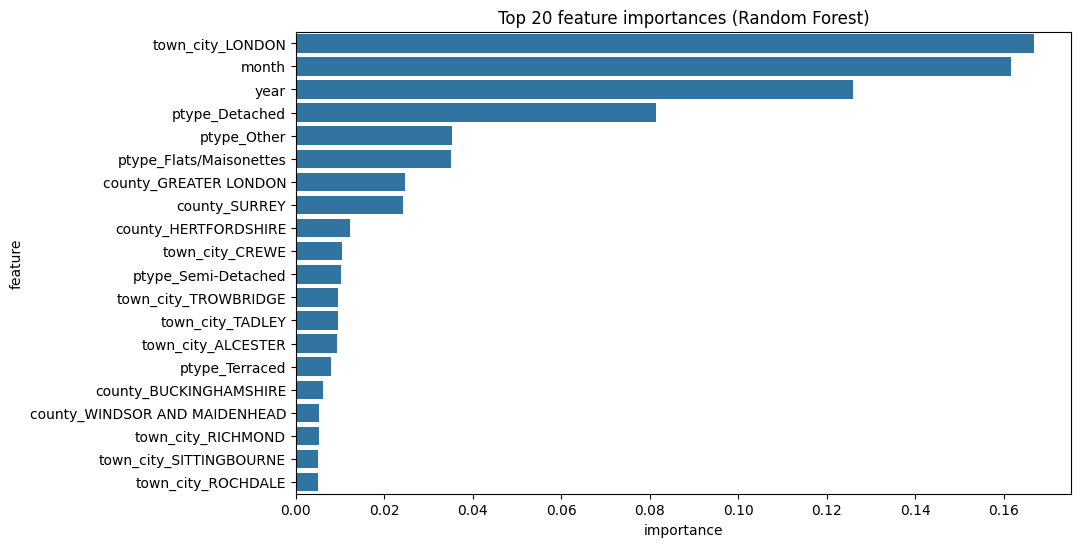

In [20]:
rf_model = models['RandomForest']
pipe = Pipeline([('preprocessor', preprocessor), ('regressor', rf_model)])
pipe.fit(X_train, y_train)

# Feature importance voor numeriek + categorisch
importances = pipe.named_steps['regressor'].feature_importances_
feature_names = (numerical_features + 
                 list(pipe.named_steps['preprocessor'].named_transformers_['cat']
                      .get_feature_names_out(categorical_features)))

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False).head(20)
plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title("Top 20 feature importances (Random Forest)")
plt.show()


In [22]:
import joblib
best_model = pipe  # bijvoorbeeld RandomForest-pipeline
joblib.dump(best_model, 'models/uk_housing_rf_pipeline.pkl', compress=8)
print("Model saved!")


Model saved!
